### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_5_1/'
summaries_path = cur_dir + 'summaries_5_1/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 5
    k = 0
    labels_list = list(range(num_class))
    seed = 1
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    while (k < num_class):
        split.append(labels_list[k : k + class_per_task])
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [13]:
t = 19
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams
    

In [14]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [15]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/19, validation accuracies: [0.2], average train loss: 1.569570, average train accuracy: 0.377878
epoch: 2, iter: 0/19, validation accuracies: [0.34], average train loss: 1.359868, average train accuracy: 0.445724
epoch: 3, iter: 0/19, validation accuracies: [0.44999999], average train loss: 1.224931, average train accuracy: 0.504934
epoch: 4, iter: 0/19, validation accuracies: [0.46000001], average train loss: 1.109441, average train accuracy: 0.575247
epoch: 5, iter: 0/19, validation accuracies: [0.56], average train loss: 1.109924, average train accuracy: 0.578536
epoch: 5, iter: 5/19, loss: 1.087229, accuracy: 0.546875
epoch: 6, iter: 0/19, validation accuracies: [0.63], average train loss: 1.027994, average train accuracy: 0.590461
epoch: 7, iter: 0/19, validation accuracies: [0.63], average train loss: 0

epoch: 63, iter: 0/19, validation accuracies: [0.74000001], average train loss: 0.159080, average train accuracy: 0.940378
epoch: 63, iter: 3/19, loss: 0.144941, accuracy: 0.960938
epoch: 64, iter: 0/19, validation accuracies: [0.75999999], average train loss: 0.128929, average train accuracy: 0.959293
epoch: 65, iter: 0/19, validation accuracies: [0.77999997], average train loss: 0.129403, average train accuracy: 0.952714
epoch: 66, iter: 0/19, validation accuracies: [0.79000002], average train loss: 0.109084, average train accuracy: 0.960938
epoch: 67, iter: 0/19, validation accuracies: [0.77999997], average train loss: 0.109687, average train accuracy: 0.962993
epoch: 68, iter: 0/19, validation accuracies: [0.77999997], average train loss: 0.096632, average train accuracy: 0.969572
epoch: 68, iter: 8/19, loss: 0.123173, accuracy: 0.945312
epoch: 69, iter: 0/19, validation accuracies: [0.79000002], average train loss: 0.123965, average train accuracy: 0.954770
epoch: 70, iter: 0/19, 

epoch: 43, iter: 0/19, validation accuracies: [0.62       0.77999997], average train loss: 0.528797, average train accuracy: 0.813734
epoch: 44, iter: 0/19, validation accuracies: [0.58999997 0.64999998], average train loss: 0.525366, average train accuracy: 0.813322
epoch: 45, iter: 0/19, validation accuracies: [0.69       0.72000003], average train loss: 0.507069, average train accuracy: 0.821135
epoch: 46, iter: 0/19, validation accuracies: [0.56999999 0.70999998], average train loss: 0.553797, average train accuracy: 0.798931
epoch: 47, iter: 0/19, validation accuracies: [0.81999999 0.70999998], average train loss: 0.565540, average train accuracy: 0.805510
epoch: 47, iter: 7/19, loss: 0.619112, accuracy: 0.750000
epoch: 48, iter: 0/19, validation accuracies: [0.58999997 0.80000001], average train loss: 0.551653, average train accuracy: 0.804276
epoch: 49, iter: 0/19, validation accuracies: [0.60000002 0.77999997], average train loss: 0.518479, average train accuracy: 0.817434
epoc

epoch: 21, iter: 0/19, validation accuracies: [0.56999999 0.69       0.68000001], average train loss: 0.845158, average train accuracy: 0.723273
epoch: 21, iter: 1/19, loss: 0.962732, accuracy: 0.664062
epoch: 22, iter: 0/19, validation accuracies: [0.56       0.73000002 0.57999998], average train loss: 0.812457, average train accuracy: 0.725740
epoch: 23, iter: 0/19, validation accuracies: [0.49000001 0.68000001 0.69      ], average train loss: 0.805099, average train accuracy: 0.728207
epoch: 24, iter: 0/19, validation accuracies: [0.54000002 0.68000001 0.68000001], average train loss: 0.736781, average train accuracy: 0.755345
epoch: 25, iter: 0/19, validation accuracies: [0.54000002 0.67000002 0.67000002], average train loss: 0.765887, average train accuracy: 0.743832
epoch: 26, iter: 0/19, validation accuracies: [0.56       0.76999998 0.69999999], average train loss: 0.771135, average train accuracy: 0.743010
epoch: 26, iter: 6/19, loss: 0.564761, accuracy: 0.789062
epoch: 27, ite

time taken: %f 0.7327558994293213
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2
INFO:tensorflow:Restoring parameters from ./checkpoints_5_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.08       0.16       0.33000001 0.11      ], average train loss: 3.821083, average train accuracy: 0.130757
epoch: 2, iter: 0/19, validation accuracies: [0.25999999 0.43000001 0.5299999

epoch: 46, iter: 0/19, validation accuracies: [0.52999997 0.74000001 0.70999998 0.49000001], average train loss: 0.803269, average train accuracy: 0.704359
epoch: 47, iter: 0/19, validation accuracies: [0.62       0.69999999 0.70999998 0.63      ], average train loss: 0.695517, average train accuracy: 0.729852
epoch: 47, iter: 7/19, loss: 0.739491, accuracy: 0.718750
epoch: 48, iter: 0/19, validation accuracies: [0.61000001 0.72000003 0.52999997 0.47999999], average train loss: 0.743127, average train accuracy: 0.719984
epoch: 49, iter: 0/19, validation accuracies: [0.61000001 0.70999998 0.81999999 0.47999999], average train loss: 0.704569, average train accuracy: 0.742188
epoch: 50, iter: 0/19, validation accuracies: [0.61000001 0.73000002 0.85000002 0.62      ], average train loss: 0.687495, average train accuracy: 0.729441
epoch: 51, iter: 0/19, validation accuracies: [0.69       0.73000002 0.81999999 0.62      ], average train loss: 0.640121, average train accuracy: 0.748355
epoch:

epoch: 18, iter: 0/19, validation accuracies: [0.47       0.47999999 0.57999998 0.47999999 0.37      ], average train loss: 1.272140, average train accuracy: 0.566201
epoch: 19, iter: 0/19, validation accuracies: [0.51999998 0.58999997 0.64999998 0.46000001 0.44      ], average train loss: 1.207530, average train accuracy: 0.585115
epoch: 20, iter: 0/19, validation accuracies: [0.47999999 0.57999998 0.56       0.41999999 0.44      ], average train loss: 1.251235, average train accuracy: 0.560444
epoch: 21, iter: 0/19, validation accuracies: [0.49000001 0.68000001 0.64999998 0.56       0.5       ], average train loss: 1.198486, average train accuracy: 0.581003
epoch: 21, iter: 1/19, loss: 1.418163, accuracy: 0.539062
epoch: 22, iter: 0/19, validation accuracies: [0.56999999 0.52999997 0.68000001 0.28999999 0.46000001], average train loss: 1.216830, average train accuracy: 0.574424
epoch: 23, iter: 0/19, validation accuracies: [0.47       0.55000001 0.68000001 0.41       0.44      ], ave

epoch: 64, iter: 0/19, validation accuracies: [0.67000002 0.77999997 0.77999997 0.58999997 0.57999998], average train loss: 0.662072, average train accuracy: 0.763569
epoch: 65, iter: 0/19, validation accuracies: [0.67000002 0.81       0.79000002 0.58999997 0.61000001], average train loss: 0.648906, average train accuracy: 0.763980
epoch: 66, iter: 0/19, validation accuracies: [0.67000002 0.81       0.77999997 0.56999999 0.61000001], average train loss: 0.597713, average train accuracy: 0.784539
epoch: 67, iter: 0/19, validation accuracies: [0.67000002 0.79000002 0.80000001 0.56999999 0.57999998], average train loss: 0.614556, average train accuracy: 0.791941
epoch: 68, iter: 0/19, validation accuracies: [0.68000001 0.77999997 0.79000002 0.56       0.57999998], average train loss: 0.643021, average train accuracy: 0.774260
epoch: 68, iter: 8/19, loss: 0.664753, accuracy: 0.789062
epoch: 69, iter: 0/19, validation accuracies: [0.68000001 0.77999997 0.80000001 0.56999999 0.56999999], ave

epoch: 31, iter: 11/19, loss: 0.851578, accuracy: 0.679688
epoch: 32, iter: 0/19, validation accuracies: [0.56       0.67000002 0.60000002 0.37       0.47       0.61000001], average train loss: 0.991922, average train accuracy: 0.631168
epoch: 33, iter: 0/19, validation accuracies: [0.56999999 0.64999998 0.73000002 0.36000001 0.51999998 0.49000001], average train loss: 1.020858, average train accuracy: 0.629112
epoch: 34, iter: 0/19, validation accuracies: [0.50999999 0.63999999 0.73000002 0.56       0.44999999 0.49000001], average train loss: 1.073617, average train accuracy: 0.590049
epoch: 35, iter: 0/19, validation accuracies: [0.63999999 0.75       0.68000001 0.46000001 0.43000001 0.47      ], average train loss: 1.045259, average train accuracy: 0.619243
epoch: 36, iter: 0/19, validation accuracies: [0.62       0.74000001 0.64999998 0.46000001 0.50999999 0.55000001], average train loss: 1.073691, average train accuracy: 0.609786
epoch: 36, iter: 16/19, loss: 1.274939, accuracy: 0

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=5
INFO:tensorflow:Restoring parameters from ./checkpoints_5_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=5.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.43000001 0.50999999 0.47999999 0.23999999 0.04       0.11
 0.20999999], average train loss: 3.024083, average train accuracy: 0.233553
epoch: 2, iter: 0/19, validation accuracies: [0.5        0.69       0.61000001 0.20999999 0.08       0.25
 0.23999999], average train loss: 2.096404, average train accuracy: 0.290707
epoch: 3, iter: 0/19, validation accuracies: [0.51999998 0.66000003 0.58999997 0.28       0.34       0.25
 0.34999999], average train loss: 1.800539, average train accuracy: 0.382812
epoch: 4, iter: 0/19, validation accuracies: [0.61000001 0.41999999 0.50999999 0.25       0.28999999 0.3

epoch: 41, iter: 0/19, validation accuracies: [0.64999998 0.70999998 0.76999998 0.41999999 0.50999999 0.55000001
 0.67000002], average train loss: 0.964277, average train accuracy: 0.670641
epoch: 42, iter: 0/19, validation accuracies: [0.57999998 0.72000003 0.63       0.44       0.52999997 0.49000001
 0.66000003], average train loss: 0.978952, average train accuracy: 0.671875
epoch: 42, iter: 2/19, loss: 1.130629, accuracy: 0.609375
epoch: 43, iter: 0/19, validation accuracies: [0.60000002 0.69999999 0.66000003 0.41       0.44999999 0.51999998
 0.61000001], average train loss: 1.050022, average train accuracy: 0.647204
epoch: 44, iter: 0/19, validation accuracies: [0.67000002 0.72000003 0.70999998 0.56       0.44       0.49000001
 0.58999997], average train loss: 1.038561, average train accuracy: 0.647204
epoch: 45, iter: 0/19, validation accuracies: [0.60000002 0.67000002 0.69999999 0.44999999 0.60000002 0.57999998
 0.67000002], average train loss: 0.976535, average train accuracy: 0

epoch: 5, iter: 5/19, loss: 1.809801, accuracy: 0.429688
epoch: 6, iter: 0/19, validation accuracies: [0.47999999 0.66000003 0.38       0.23       0.18000001 0.38
 0.38       0.40000001], average train loss: 1.798921, average train accuracy: 0.464638
epoch: 7, iter: 0/19, validation accuracies: [0.49000001 0.60000002 0.44       0.23       0.22       0.43000001
 0.57999998 0.47      ], average train loss: 1.744702, average train accuracy: 0.464638
epoch: 8, iter: 0/19, validation accuracies: [0.50999999 0.55000001 0.56999999 0.38       0.17       0.46000001
 0.5        0.38      ], average train loss: 1.642718, average train accuracy: 0.497533
epoch: 9, iter: 0/19, validation accuracies: [0.44999999 0.60000002 0.56       0.20999999 0.23999999 0.56
 0.43000001 0.5       ], average train loss: 1.568119, average train accuracy: 0.500822
epoch: 10, iter: 0/19, validation accuracies: [0.56       0.54000002 0.66000003 0.31999999 0.41999999 0.36000001
 0.47999999 0.44      ], average train los

epoch: 45, iter: 0/19, validation accuracies: [0.57999998 0.63       0.61000001 0.43000001 0.36000001 0.5
 0.56999999 0.63      ], average train loss: 1.167761, average train accuracy: 0.638569
epoch: 46, iter: 0/19, validation accuracies: [0.63999999 0.76999998 0.60000002 0.34999999 0.58999997 0.44
 0.63       0.76999998], average train loss: 1.082081, average train accuracy: 0.654194
epoch: 47, iter: 0/19, validation accuracies: [0.57999998 0.56999999 0.69       0.49000001 0.47999999 0.55000001
 0.66000003 0.57999998], average train loss: 1.048475, average train accuracy: 0.679276
epoch: 47, iter: 7/19, loss: 1.060686, accuracy: 0.656250
epoch: 48, iter: 0/19, validation accuracies: [0.47999999 0.63999999 0.67000002 0.43000001 0.40000001 0.50999999
 0.69999999 0.66000003], average train loss: 1.044332, average train accuracy: 0.671464
epoch: 49, iter: 0/19, validation accuracies: [0.47999999 0.55000001 0.57999998 0.31       0.58999997 0.41999999
 0.67000002 0.66000003], average train

epoch: 8, iter: 0/19, validation accuracies: [0.44       0.44       0.51999998 0.34       0.27000001 0.46000001
 0.47999999 0.33000001 0.37      ], average train loss: 1.913242, average train accuracy: 0.399671
epoch: 9, iter: 0/19, validation accuracies: [0.46000001 0.66000003 0.47999999 0.30000001 0.23999999 0.44
 0.51999998 0.37       0.34999999], average train loss: 1.878874, average train accuracy: 0.410773
epoch: 10, iter: 0/19, validation accuracies: [0.54000002 0.54000002 0.56       0.34999999 0.40000001 0.41
 0.44999999 0.46000001 0.40000001], average train loss: 1.655117, average train accuracy: 0.457648
epoch: 10, iter: 10/19, loss: 1.596162, accuracy: 0.468750
epoch: 11, iter: 0/19, validation accuracies: [0.40000001 0.61000001 0.66000003 0.34       0.41999999 0.47
 0.56       0.47999999 0.34999999], average train loss: 1.602966, average train accuracy: 0.467105
epoch: 12, iter: 0/19, validation accuracies: [0.52999997 0.51999998 0.46000001 0.37       0.18000001 0.56999999


epoch: 46, iter: 0/19, validation accuracies: [0.57999998 0.63       0.69       0.44999999 0.36000001 0.62
 0.52999997 0.58999997 0.60000002], average train loss: 1.139056, average train accuracy: 0.665707
epoch: 47, iter: 0/19, validation accuracies: [0.60000002 0.74000001 0.67000002 0.37       0.38999999 0.47999999
 0.73000002 0.72000003 0.51999998], average train loss: 1.056881, average train accuracy: 0.664885
epoch: 47, iter: 7/19, loss: 1.173805, accuracy: 0.718750
epoch: 48, iter: 0/19, validation accuracies: [0.44       0.58999997 0.64999998 0.52999997 0.47       0.60000002
 0.61000001 0.63999999 0.55000001], average train loss: 1.051524, average train accuracy: 0.689145
epoch: 49, iter: 0/19, validation accuracies: [0.56       0.61000001 0.67000002 0.49000001 0.37       0.56999999
 0.56       0.56       0.56999999], average train loss: 1.044806, average train accuracy: 0.646793
epoch: 50, iter: 0/19, validation accuracies: [0.52999997 0.70999998 0.64999998 0.50999999 0.5500000

epoch: 8, iter: 0/19, validation accuracies: [0.50999999 0.60000002 0.5        0.31999999 0.28       0.41
 0.49000001 0.50999999 0.28       0.38999999], average train loss: 1.765533, average train accuracy: 0.376234
epoch: 9, iter: 0/19, validation accuracies: [0.56       0.62       0.51999998 0.33000001 0.43000001 0.41999999
 0.55000001 0.41       0.36000001 0.27000001], average train loss: 1.664029, average train accuracy: 0.407895
epoch: 10, iter: 0/19, validation accuracies: [0.52999997 0.66000003 0.43000001 0.34999999 0.38999999 0.43000001
 0.55000001 0.57999998 0.41999999 0.40000001], average train loss: 1.714816, average train accuracy: 0.404605
epoch: 10, iter: 10/19, loss: 1.459409, accuracy: 0.429688
epoch: 11, iter: 0/19, validation accuracies: [0.43000001 0.49000001 0.58999997 0.17       0.38999999 0.49000001
 0.67000002 0.49000001 0.38999999 0.41      ], average train loss: 1.618141, average train accuracy: 0.420641
epoch: 12, iter: 0/19, validation accuracies: [0.54000002

epoch: 44, iter: 0/19, validation accuracies: [0.52999997 0.73000002 0.55000001 0.36000001 0.36000001 0.56
 0.60000002 0.68000001 0.51999998 0.57999998], average train loss: 1.210770, average train accuracy: 0.575658
epoch: 45, iter: 0/19, validation accuracies: [0.49000001 0.66000003 0.64999998 0.37       0.41999999 0.34999999
 0.69999999 0.56       0.57999998 0.44      ], average train loss: 1.190169, average train accuracy: 0.575247
epoch: 46, iter: 0/19, validation accuracies: [0.51999998 0.66000003 0.76999998 0.37       0.27000001 0.55000001
 0.56       0.52999997 0.64999998 0.46000001], average train loss: 1.131006, average train accuracy: 0.585115
epoch: 47, iter: 0/19, validation accuracies: [0.51999998 0.80000001 0.43000001 0.44       0.41999999 0.61000001
 0.70999998 0.63999999 0.46000001 0.44      ], average train loss: 1.172601, average train accuracy: 0.602796
epoch: 47, iter: 7/19, loss: 1.154530, accuracy: 0.507812
epoch: 48, iter: 0/19, validation accuracies: [0.4799999

epoch: 4, iter: 0/19, validation accuracies: [0.22       0.17       0.28999999 0.34999999 0.15000001 0.2
 0.23       0.28       0.15000001 0.19       0.33000001], average train loss: 3.034711, average train accuracy: 0.222451
epoch: 5, iter: 0/19, validation accuracies: [0.28999999 0.23       0.33000001 0.09       0.23       0.33000001
 0.15000001 0.52999997 0.28       0.15000001 0.40000001], average train loss: 2.713223, average train accuracy: 0.294819
epoch: 5, iter: 5/19, loss: 2.649242, accuracy: 0.320312
epoch: 6, iter: 0/19, validation accuracies: [0.25999999 0.25       0.52999997 0.22       0.18000001 0.28
 0.25       0.5        0.37       0.25999999 0.30000001], average train loss: 2.504267, average train accuracy: 0.339227
epoch: 7, iter: 0/19, validation accuracies: [0.2        0.28999999 0.55000001 0.33000001 0.34999999 0.31999999
 0.33000001 0.31999999 0.20999999 0.14       0.41999999], average train loss: 2.281703, average train accuracy: 0.349507
epoch: 8, iter: 0/19, va

epoch: 38, iter: 0/19, validation accuracies: [0.47999999 0.56999999 0.62       0.46000001 0.37       0.50999999
 0.61000001 0.64999998 0.47999999 0.47       0.58999997], average train loss: 1.289625, average train accuracy: 0.586760
epoch: 39, iter: 0/19, validation accuracies: [0.46000001 0.61000001 0.57999998 0.37       0.44       0.41999999
 0.66000003 0.68000001 0.47999999 0.44999999 0.54000002], average train loss: 1.417641, average train accuracy: 0.550987
epoch: 40, iter: 0/19, validation accuracies: [0.55000001 0.60000002 0.63       0.49000001 0.41999999 0.51999998
 0.63999999 0.52999997 0.60000002 0.54000002 0.47999999], average train loss: 1.364553, average train accuracy: 0.575658
epoch: 41, iter: 0/19, validation accuracies: [0.49000001 0.63       0.61000001 0.49000001 0.51999998 0.40000001
 0.58999997 0.55000001 0.5        0.66000003 0.49000001], average train loss: 1.366730, average train accuracy: 0.579359
epoch: 42, iter: 0/19, validation accuracies: [0.51999998 0.6700

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10 at time step 1330
calculating penultimate output...
time taken: %f 2.4718358516693115
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=11
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10
INFO:tensorflow:Restoring parameters from ./checkpoints_5_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10.ckpt-1330
epoch: 1, iter: 0/19, validation acc

epoch: 30, iter: 0/19, validation accuracies: [0.49000001 0.60000002 0.67000002 0.28       0.54000002 0.41
 0.56       0.56       0.55000001 0.47       0.41999999 0.31999999], average train loss: 1.459918, average train accuracy: 0.531250
epoch: 31, iter: 0/19, validation accuracies: [0.43000001 0.69       0.54000002 0.38       0.34999999 0.41999999
 0.69       0.52999997 0.51999998 0.51999998 0.54000002 0.51999998], average train loss: 1.463280, average train accuracy: 0.536184
epoch: 31, iter: 11/19, loss: 1.752553, accuracy: 0.539062
epoch: 32, iter: 0/19, validation accuracies: [0.5        0.51999998 0.66000003 0.38999999 0.44       0.47
 0.57999998 0.49000001 0.50999999 0.41999999 0.46000001 0.37      ], average train loss: 1.386820, average train accuracy: 0.551398
epoch: 33, iter: 0/19, validation accuracies: [0.44999999 0.50999999 0.51999998 0.38999999 0.47       0.40000001
 0.63       0.56999999 0.41999999 0.49000001 0.44999999 0.41      ], average train loss: 1.414993, averag

epoch: 63, iter: 0/19, validation accuracies: [0.55000001 0.75999999 0.63       0.55000001 0.56       0.55000001
 0.69       0.69999999 0.60000002 0.62       0.56999999 0.50999999], average train loss: 0.994833, average train accuracy: 0.655428
epoch: 63, iter: 3/19, loss: 0.936531, accuracy: 0.656250
epoch: 64, iter: 0/19, validation accuracies: [0.56       0.76999998 0.62       0.54000002 0.55000001 0.56999999
 0.68000001 0.69       0.57999998 0.61000001 0.57999998 0.51999998], average train loss: 1.014024, average train accuracy: 0.648026
epoch: 65, iter: 0/19, validation accuracies: [0.56999999 0.76999998 0.63999999 0.52999997 0.54000002 0.60000002
 0.68000001 0.68000001 0.58999997 0.63999999 0.55000001 0.54000002], average train loss: 1.037042, average train accuracy: 0.656250
epoch: 66, iter: 0/19, validation accuracies: [0.58999997 0.75999999 0.68000001 0.52999997 0.52999997 0.57999998
 0.69       0.69       0.57999998 0.62       0.55000001 0.52999997], average train loss: 1.020

epoch: 20, iter: 0/19, validation accuracies: [0.5        0.58999997 0.58999997 0.37       0.23       0.51999998
 0.54000002 0.64999998 0.46000001 0.40000001 0.38       0.43000001
 0.38999999], average train loss: 1.569175, average train accuracy: 0.493010
epoch: 21, iter: 0/19, validation accuracies: [0.5        0.64999998 0.60000002 0.36000001 0.44       0.36000001
 0.52999997 0.47       0.41       0.50999999 0.49000001 0.41
 0.31      ], average train loss: 1.648253, average train accuracy: 0.462582
epoch: 21, iter: 1/19, loss: 1.178765, accuracy: 0.523438
epoch: 22, iter: 0/19, validation accuracies: [0.36000001 0.69       0.49000001 0.5        0.23999999 0.37
 0.55000001 0.5        0.54000002 0.47       0.52999997 0.34999999
 0.31999999], average train loss: 1.506672, average train accuracy: 0.485609
epoch: 23, iter: 0/19, validation accuracies: [0.55000001 0.72000003 0.52999997 0.37       0.28999999 0.44
 0.55000001 0.61000001 0.44999999 0.38999999 0.47999999 0.41
 0.44999999], a

epoch: 51, iter: 0/19, validation accuracies: [0.55000001 0.73000002 0.62       0.5        0.47999999 0.51999998
 0.57999998 0.69       0.60000002 0.57999998 0.62       0.56
 0.5       ], average train loss: 1.229434, average train accuracy: 0.599095
epoch: 52, iter: 0/19, validation accuracies: [0.57999998 0.73000002 0.58999997 0.49000001 0.54000002 0.56
 0.67000002 0.70999998 0.64999998 0.62       0.57999998 0.60000002
 0.51999998], average train loss: 1.180507, average train accuracy: 0.598273
epoch: 52, iter: 12/19, loss: 0.996403, accuracy: 0.625000
epoch: 53, iter: 0/19, validation accuracies: [0.54000002 0.75       0.70999998 0.49000001 0.47999999 0.51999998
 0.69       0.74000001 0.63999999 0.61000001 0.60000002 0.56999999
 0.43000001], average train loss: 1.207073, average train accuracy: 0.592928
epoch: 54, iter: 0/19, validation accuracies: [0.56       0.75999999 0.68000001 0.52999997 0.41999999 0.58999997
 0.64999998 0.68000001 0.60000002 0.56999999 0.62       0.57999998
 0

epoch: 7, iter: 0/19, validation accuracies: [0.23999999 0.41999999 0.31999999 0.15000001 0.2        0.33000001
 0.20999999 0.46000001 0.47       0.2        0.41       0.19
 0.14       0.43000001], average train loss: 2.610549, average train accuracy: 0.384046
epoch: 8, iter: 0/19, validation accuracies: [0.2        0.5        0.55000001 0.16       0.04       0.30000001
 0.33000001 0.46000001 0.40000001 0.23999999 0.41999999 0.31999999
 0.05       0.56999999], average train loss: 2.356140, average train accuracy: 0.435444
epoch: 9, iter: 0/19, validation accuracies: [0.25       0.47       0.41       0.23999999 0.52999997 0.25
 0.31       0.44       0.27000001 0.37       0.40000001 0.28
 0.13       0.5       ], average train loss: 2.225523, average train accuracy: 0.424753
epoch: 10, iter: 0/19, validation accuracies: [0.25999999 0.52999997 0.5        0.31       0.13       0.41
 0.56999999 0.38999999 0.27000001 0.23999999 0.28999999 0.27000001
 0.16       0.50999999], average train loss

epoch: 36, iter: 16/19, loss: 1.537608, accuracy: 0.593750
epoch: 37, iter: 0/19, validation accuracies: [0.36000001 0.67000002 0.47999999 0.41       0.50999999 0.49000001
 0.51999998 0.61000001 0.52999997 0.38       0.41999999 0.57999998
 0.43000001 0.64999998], average train loss: 1.478429, average train accuracy: 0.575658
epoch: 38, iter: 0/19, validation accuracies: [0.46000001 0.63       0.66000003 0.38       0.34       0.41
 0.55000001 0.50999999 0.52999997 0.40000001 0.34       0.34999999
 0.23999999 0.56      ], average train loss: 1.464915, average train accuracy: 0.604030
epoch: 39, iter: 0/19, validation accuracies: [0.51999998 0.60000002 0.49000001 0.37       0.37       0.47
 0.56999999 0.51999998 0.41999999 0.5        0.50999999 0.54000002
 0.54000002 0.63      ], average train loss: 1.565747, average train accuracy: 0.592516
epoch: 40, iter: 0/19, validation accuracies: [0.40000001 0.62       0.40000001 0.34999999 0.37       0.5
 0.63       0.54000002 0.43000001 0.2700000

epoch: 67, iter: 0/19, validation accuracies: [0.50999999 0.73000002 0.68000001 0.47       0.43000001 0.61000001
 0.60000002 0.72000003 0.58999997 0.61000001 0.56999999 0.60000002
 0.46000001 0.72000003], average train loss: 1.139162, average train accuracy: 0.682977
epoch: 68, iter: 0/19, validation accuracies: [0.50999999 0.73000002 0.67000002 0.51999998 0.46000001 0.62
 0.63999999 0.72000003 0.58999997 0.60000002 0.57999998 0.56
 0.44       0.69      ], average train loss: 1.129937, average train accuracy: 0.696546
epoch: 68, iter: 8/19, loss: 0.908927, accuracy: 0.726562
epoch: 69, iter: 0/19, validation accuracies: [0.51999998 0.70999998 0.64999998 0.50999999 0.44       0.61000001
 0.63999999 0.69       0.56999999 0.56999999 0.58999997 0.56
 0.44999999 0.69      ], average train loss: 1.100988, average train accuracy: 0.701891
epoch: 70, iter: 0/19, validation accuracies: [0.52999997 0.70999998 0.66000003 0.50999999 0.41       0.61000001
 0.64999998 0.69999999 0.56999999 0.5899999

epoch: 22, iter: 0/19, validation accuracies: [0.41999999 0.69       0.58999997 0.30000001 0.44999999 0.41
 0.66000003 0.54000002 0.5        0.31       0.40000001 0.33000001
 0.34       0.58999997 0.33000001], average train loss: 1.700071, average train accuracy: 0.447780
epoch: 23, iter: 0/19, validation accuracies: [0.34       0.56       0.69999999 0.38       0.36000001 0.41
 0.44999999 0.52999997 0.5        0.49000001 0.47       0.5
 0.36000001 0.5        0.36000001], average train loss: 1.624300, average train accuracy: 0.461349
epoch: 24, iter: 0/19, validation accuracies: [0.44       0.55000001 0.56999999 0.31999999 0.5        0.49000001
 0.47999999 0.64999998 0.44999999 0.38       0.57999998 0.5
 0.37       0.66000003 0.43000001], average train loss: 1.619624, average train accuracy: 0.483553
epoch: 25, iter: 0/19, validation accuracies: [0.38999999 0.57999998 0.56       0.28       0.34999999 0.37
 0.63999999 0.66000003 0.44999999 0.56999999 0.56999999 0.41999999
 0.28999999 0.5

epoch: 51, iter: 0/19, validation accuracies: [0.56       0.69999999 0.63999999 0.40000001 0.44       0.60000002
 0.63999999 0.69999999 0.52999997 0.56999999 0.58999997 0.58999997
 0.41       0.63       0.47999999], average train loss: 1.270714, average train accuracy: 0.567845
epoch: 52, iter: 0/19, validation accuracies: [0.57999998 0.69       0.68000001 0.43000001 0.38       0.60000002
 0.67000002 0.67000002 0.55000001 0.58999997 0.63999999 0.60000002
 0.49000001 0.63       0.49000001], average train loss: 1.283386, average train accuracy: 0.566612
epoch: 52, iter: 12/19, loss: 1.073729, accuracy: 0.578125
epoch: 53, iter: 0/19, validation accuracies: [0.51999998 0.69999999 0.63999999 0.44       0.44       0.58999997
 0.69       0.63       0.57999998 0.60000002 0.62       0.62
 0.52999997 0.67000002 0.47999999], average train loss: 1.209930, average train accuracy: 0.589227
epoch: 54, iter: 0/19, validation accuracies: [0.54000002 0.69999999 0.61000001 0.43000001 0.47999999 0.579999

epoch: 5, iter: 0/19, validation accuracies: [0.43000001 0.25999999 0.23999999 0.13       0.23       0.28
 0.31999999 0.40000001 0.09       0.25       0.16       0.17
 0.08       0.38999999 0.40000001 0.12      ], average train loss: 2.952372, average train accuracy: 0.215461
epoch: 5, iter: 5/19, loss: 2.935879, accuracy: 0.203125
epoch: 6, iter: 0/19, validation accuracies: [0.46000001 0.40000001 0.20999999 0.33000001 0.41       0.25
 0.31       0.54000002 0.17       0.2        0.22       0.19
 0.2        0.56       0.28       0.17      ], average train loss: 2.789571, average train accuracy: 0.250822
epoch: 7, iter: 0/19, validation accuracies: [0.47999999 0.43000001 0.31999999 0.19       0.28999999 0.34
 0.25999999 0.34999999 0.31       0.36000001 0.38999999 0.33000001
 0.19       0.33000001 0.23999999 0.22      ], average train loss: 2.518296, average train accuracy: 0.300987
epoch: 8, iter: 0/19, validation accuracies: [0.38       0.25999999 0.36000001 0.23       0.41       0.349

epoch: 33, iter: 0/19, validation accuracies: [0.28999999 0.56999999 0.60000002 0.34       0.44999999 0.41
 0.69       0.51999998 0.47999999 0.38999999 0.47       0.52999997
 0.52999997 0.56999999 0.44999999 0.41999999], average train loss: 1.642101, average train accuracy: 0.496711
epoch: 34, iter: 0/19, validation accuracies: [0.61000001 0.55000001 0.56       0.34999999 0.49000001 0.37
 0.61000001 0.63       0.47       0.49000001 0.36000001 0.38
 0.37       0.56       0.44       0.50999999], average train loss: 1.625827, average train accuracy: 0.495888
epoch: 35, iter: 0/19, validation accuracies: [0.40000001 0.56       0.57999998 0.28       0.36000001 0.52999997
 0.54000002 0.54000002 0.43000001 0.43000001 0.43000001 0.44999999
 0.38       0.58999997 0.55000001 0.44      ], average train loss: 1.562685, average train accuracy: 0.553043
epoch: 36, iter: 0/19, validation accuracies: [0.50999999 0.57999998 0.46000001 0.38999999 0.43000001 0.50999999
 0.63       0.58999997 0.40000001 0

epoch: 61, iter: 0/19, validation accuracies: [0.51999998 0.66000003 0.67000002 0.43000001 0.44       0.56
 0.69       0.68000001 0.55000001 0.57999998 0.52999997 0.55000001
 0.49000001 0.74000001 0.56       0.58999997], average train loss: 1.203152, average train accuracy: 0.622122
epoch: 62, iter: 0/19, validation accuracies: [0.47       0.67000002 0.57999998 0.38       0.46000001 0.63999999
 0.72000003 0.64999998 0.58999997 0.63       0.52999997 0.47999999
 0.43000001 0.74000001 0.5        0.57999998], average train loss: 1.251584, average train accuracy: 0.618010
epoch: 63, iter: 0/19, validation accuracies: [0.49000001 0.68000001 0.68000001 0.43000001 0.50999999 0.60000002
 0.76999998 0.64999998 0.56       0.46000001 0.52999997 0.5
 0.41999999 0.74000001 0.57999998 0.55000001], average train loss: 1.280238, average train accuracy: 0.609786
epoch: 63, iter: 3/19, loss: 1.421945, accuracy: 0.531250
epoch: 64, iter: 0/19, validation accuracies: [0.5        0.69       0.68000001 0.44 

epoch: 14, iter: 0/19, validation accuracies: [0.44999999 0.67000002 0.43000001 0.20999999 0.43000001 0.31
 0.47999999 0.56       0.34999999 0.36000001 0.44       0.44999999
 0.30000001 0.63       0.50999999 0.46000001 0.34      ], average train loss: 1.904835, average train accuracy: 0.414062
epoch: 15, iter: 0/19, validation accuracies: [0.28       0.54000002 0.51999998 0.31999999 0.30000001 0.40000001
 0.47999999 0.56       0.33000001 0.41999999 0.44999999 0.34999999
 0.25999999 0.44       0.34       0.41       0.33000001], average train loss: 1.953383, average train accuracy: 0.427632
epoch: 15, iter: 15/19, loss: 2.164656, accuracy: 0.414062
epoch: 16, iter: 0/19, validation accuracies: [0.44999999 0.68000001 0.50999999 0.30000001 0.23       0.43000001
 0.38       0.38       0.36000001 0.40000001 0.38       0.47
 0.44       0.55000001 0.52999997 0.34       0.31      ], average train loss: 1.963132, average train accuracy: 0.432566
epoch: 17, iter: 0/19, validation accuracies: [0.3

epoch: 41, iter: 0/19, validation accuracies: [0.33000001 0.37       0.57999998 0.38       0.23       0.38
 0.54000002 0.64999998 0.61000001 0.54000002 0.41999999 0.49000001
 0.47       0.52999997 0.44999999 0.49000001 0.50999999], average train loss: 1.605808, average train accuracy: 0.504934
epoch: 42, iter: 0/19, validation accuracies: [0.44       0.75       0.49000001 0.31999999 0.43000001 0.47999999
 0.56       0.66000003 0.44999999 0.43000001 0.37       0.49000001
 0.40000001 0.68000001 0.57999998 0.40000001 0.37      ], average train loss: 1.620506, average train accuracy: 0.521793
epoch: 42, iter: 2/19, loss: 1.471747, accuracy: 0.500000
epoch: 43, iter: 0/19, validation accuracies: [0.51999998 0.66000003 0.51999998 0.34       0.25999999 0.36000001
 0.47       0.58999997 0.51999998 0.50999999 0.47       0.38
 0.46000001 0.63999999 0.44       0.51999998 0.44      ], average train loss: 1.568064, average train accuracy: 0.497944
epoch: 44, iter: 0/19, validation accuracies: [0.41

epoch: 68, iter: 0/19, validation accuracies: [0.50999999 0.75       0.66000003 0.43000001 0.47999999 0.52999997
 0.61000001 0.70999998 0.63999999 0.56999999 0.52999997 0.58999997
 0.5        0.68000001 0.58999997 0.60000002 0.52999997], average train loss: 1.272662, average train accuracy: 0.594161
epoch: 68, iter: 8/19, loss: 1.218684, accuracy: 0.578125
epoch: 69, iter: 0/19, validation accuracies: [0.49000001 0.77999997 0.62       0.41999999 0.47999999 0.55000001
 0.64999998 0.72000003 0.63999999 0.62       0.55000001 0.58999997
 0.47       0.69       0.57999998 0.61000001 0.52999997], average train loss: 1.150929, average train accuracy: 0.617599
epoch: 70, iter: 0/19, validation accuracies: [0.47999999 0.75999999 0.61000001 0.40000001 0.5        0.52999997
 0.62       0.69       0.66000003 0.62       0.56999999 0.60000002
 0.47999999 0.69       0.56999999 0.60000002 0.54000002], average train loss: 1.193162, average train accuracy: 0.599507
epochs: 70.000000, final train loss: 1.

epoch: 20, iter: 0/19, validation accuracies: [0.31999999 0.47       0.36000001 0.2        0.44999999 0.41
 0.44       0.34999999 0.56       0.40000001 0.54000002 0.37
 0.17       0.58999997 0.34       0.46000001 0.38       0.41999999], average train loss: 1.848371, average train accuracy: 0.433388
epoch: 21, iter: 0/19, validation accuracies: [0.33000001 0.56       0.56999999 0.09       0.23999999 0.46000001
 0.62       0.5        0.38       0.31999999 0.40000001 0.44
 0.30000001 0.66000003 0.34999999 0.30000001 0.41999999 0.30000001], average train loss: 1.790516, average train accuracy: 0.455592
epoch: 21, iter: 1/19, loss: 2.061684, accuracy: 0.453125
epoch: 22, iter: 0/19, validation accuracies: [0.37       0.50999999 0.63       0.28999999 0.20999999 0.38999999
 0.44       0.63999999 0.40000001 0.40000001 0.31999999 0.41
 0.25       0.51999998 0.52999997 0.44999999 0.47       0.44999999], average train loss: 1.877630, average train accuracy: 0.415707
epoch: 23, iter: 0/19, validat

epoch: 46, iter: 0/19, validation accuracies: [0.41       0.56999999 0.56       0.34       0.27000001 0.36000001
 0.62       0.51999998 0.56999999 0.46000001 0.56       0.33000001
 0.44       0.64999998 0.52999997 0.44999999 0.5        0.5       ], average train loss: 1.553511, average train accuracy: 0.522204
epoch: 47, iter: 0/19, validation accuracies: [0.47       0.61000001 0.34999999 0.34999999 0.55000001 0.36000001
 0.56       0.66000003 0.50999999 0.56       0.41999999 0.55000001
 0.31       0.63       0.5        0.51999998 0.40000001 0.5       ], average train loss: 1.654380, average train accuracy: 0.525905
epoch: 47, iter: 7/19, loss: 1.394486, accuracy: 0.507812
epoch: 48, iter: 0/19, validation accuracies: [0.44999999 0.49000001 0.68000001 0.22       0.25999999 0.28999999
 0.55000001 0.56999999 0.51999998 0.50999999 0.47999999 0.52999997
 0.41999999 0.51999998 0.56       0.43000001 0.47       0.41      ], average train loss: 1.559882, average train accuracy: 0.521382
epoch:

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17 at time step 1330
calculating penultimate output...
time taken: %f 4.2282702922821045
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=18
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17
INFO:tensorflow:Restoring parameters from ./checkpoints_5_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17.ckpt-1330
epoch: 1, iter: 0/19, validation acc

epoch: 24, iter: 0/19, validation accuracies: [0.31999999 0.5        0.43000001 0.31999999 0.36000001 0.34999999
 0.44999999 0.47999999 0.49000001 0.47       0.47999999 0.34999999
 0.49000001 0.64999998 0.46000001 0.51999998 0.37       0.40000001
 0.25      ], average train loss: 1.858576, average train accuracy: 0.427632
epoch: 25, iter: 0/19, validation accuracies: [0.41999999 0.47999999 0.49000001 0.38999999 0.31       0.27000001
 0.44999999 0.54000002 0.63       0.43000001 0.49000001 0.50999999
 0.34999999 0.50999999 0.41       0.30000001 0.47999999 0.34
 0.28999999], average train loss: 1.840765, average train accuracy: 0.409951
epoch: 26, iter: 0/19, validation accuracies: [0.37       0.50999999 0.50999999 0.38999999 0.33000001 0.49000001
 0.56999999 0.50999999 0.46000001 0.44999999 0.38999999 0.60000002
 0.34       0.51999998 0.28       0.41999999 0.33000001 0.40000001
 0.28999999], average train loss: 1.870332, average train accuracy: 0.399671
epoch: 26, iter: 6/19, loss: 2.141

epoch: 49, iter: 0/19, validation accuracies: [0.34       0.58999997 0.68000001 0.31999999 0.47999999 0.43000001
 0.62       0.54000002 0.56999999 0.44999999 0.33000001 0.43000001
 0.30000001 0.74000001 0.47999999 0.47999999 0.43000001 0.36000001
 0.28      ], average train loss: 1.744904, average train accuracy: 0.451891
epoch: 50, iter: 0/19, validation accuracies: [0.34999999 0.63999999 0.60000002 0.40000001 0.43000001 0.44999999
 0.62       0.63       0.57999998 0.56999999 0.47999999 0.50999999
 0.5        0.68000001 0.47999999 0.51999998 0.49000001 0.43000001
 0.38999999], average train loss: 1.611445, average train accuracy: 0.472451
epoch: 51, iter: 0/19, validation accuracies: [0.34999999 0.63       0.55000001 0.44       0.37       0.38
 0.69999999 0.61000001 0.63       0.62       0.56999999 0.54000002
 0.56       0.67000002 0.5        0.55000001 0.52999997 0.49000001
 0.38999999], average train loss: 1.533775, average train accuracy: 0.537007
epoch: 52, iter: 0/19, validation 

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=19
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=18
INFO:tensorflow:Restoring parameters from ./checkpoints_5_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=18.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.11 0.31 0.11 0.   0.13 0.07 0.14 0.   0.02 0.01 0.14 0.02 0.01 0.05
 0.   0.07 0.   0.05 0.06 0.  ], average train loss: 5.786612, average train accuracy: 0.046464
epoch: 2, iter: 0/19, validation accuracies: [0.33000001 0.54000002 0.11       0.         0.1        0.19
 0.11       0.         0.07       0.14       0.08       0.1
 0.05       0.18000001 0.04       0.05       0.02       0.08
 0.         0.07      ], average train loss: 4.11

epoch: 25, iter: 0/19, validation accuracies: [0.37       0.43000001 0.56       0.5        0.40000001 0.40000001
 0.60000002 0.47999999 0.49000001 0.49000001 0.44999999 0.38999999
 0.34       0.50999999 0.47999999 0.34       0.41       0.34999999
 0.20999999 0.34      ], average train loss: 1.886717, average train accuracy: 0.425987
epoch: 26, iter: 0/19, validation accuracies: [0.49000001 0.47999999 0.47999999 0.27000001 0.25       0.50999999
 0.56       0.51999998 0.52999997 0.47999999 0.37       0.25
 0.38999999 0.60000002 0.41       0.55000001 0.43000001 0.34
 0.34       0.41      ], average train loss: 1.933157, average train accuracy: 0.409539
epoch: 26, iter: 6/19, loss: 1.756410, accuracy: 0.531250
epoch: 27, iter: 0/19, validation accuracies: [0.49000001 0.52999997 0.34       0.33000001 0.38999999 0.38
 0.5        0.44       0.41999999 0.44999999 0.47999999 0.47
 0.49000001 0.67000002 0.51999998 0.43000001 0.34999999 0.41999999
 0.23       0.43000001], average train loss: 1.83

epoch: 49, iter: 0/19, validation accuracies: [0.57999998 0.50999999 0.57999998 0.37       0.30000001 0.36000001
 0.49000001 0.47999999 0.49000001 0.56       0.38999999 0.44999999
 0.56999999 0.46000001 0.56999999 0.5        0.47       0.40000001
 0.31       0.40000001], average train loss: 1.691567, average train accuracy: 0.503289
epoch: 50, iter: 0/19, validation accuracies: [0.46000001 0.56999999 0.57999998 0.31999999 0.46000001 0.40000001
 0.58999997 0.63999999 0.58999997 0.60000002 0.52999997 0.47
 0.50999999 0.58999997 0.60000002 0.52999997 0.54000002 0.47
 0.40000001 0.50999999], average train loss: 1.676912, average train accuracy: 0.492188
epoch: 51, iter: 0/19, validation accuracies: [0.46000001 0.60000002 0.60000002 0.31999999 0.41999999 0.47
 0.61000001 0.62       0.57999998 0.60000002 0.57999998 0.51999998
 0.5        0.68000001 0.60000002 0.52999997 0.54000002 0.47999999
 0.40000001 0.49000001], average train loss: 1.565866, average train accuracy: 0.524671
epoch: 52, it

time taken: %f 4.000884771347046
saving penultimate output...


In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# Weights given to each class
num_class = 100
for i in range(num_class):
    print(i, np.sum(tuner.appended_task_list[-1].train.weights[(np.argmax(tuner.appended_task_list[-1].train.labels, axis=1) == i)]))

In [16]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [17]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints_5_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=4.ckpt-1330
INFO:tensorflow:Rest

/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


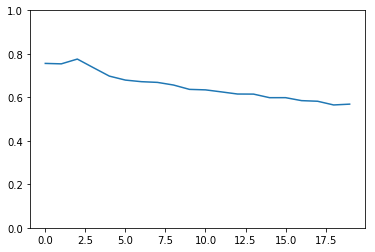

In [18]:
plt.plot(test_accuracies)
plt.ylim(ymin=0, ymax=1)
plt.show()

In [19]:
print(np.mean(test_accuracies))

0.6510136224492614


In [ ]:
%store -r DB1_test_accuracies
plt.plot(test_accuracies, color='g')
plt.plot(DB1_test_accuracies, color='b')
plt.ylim(ymin=0, ymax=1)
plt.show()

In [ ]:
plt.hist(tuner.appended_task_list[-1].train.weights[0 : tuner.appended_task_list[-2].train.weights.shape[0]], bins='auto')

In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()